# Problem 1: Clustering

### A leading bank wants to develop a customer segmentation to give promotional offers to its customers. They collected a sample that summarizes the activities of users during the past few months. You are given the task to identify the segments based on credit card usage.



### Data Dictionary for Market Segmentation:

1. spending: Amount spent by the customer per month (in 1000s)
2. advance_payments: Amount paid by the customer in advance by cash (in 100s)
3. probability_of_full_payment: Probability of payment done in full by the customer to the bank
4. current_balance: Balance amount left in the account to make purchases (in 1000s)
5. credit_limit: Limit of the amount in credit card (10000s)
6. min_payment_amt : minimum paid by the customer while making payments for purchases made monthly (in 100s)
7. max_spent_in_single_shopping: Maximum amount spent in one purchase (in 1000s)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans 
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import zscore
import scipy.stats as ss
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
import warnings
warnings.filterwarnings("ignore") 
my_colors = ['#d3d3d3','#d1a163','#7a7a7a','#d4a07d','#ffbf65','#202020']

## 1.1 Read the data, do the necessary initial steps, and exploratory data analysis (Univariate, Bi-variate, and multivariate analysis).

In [2]:
df=pd.read_csv("download-16.csv")

In [3]:
df.head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping
0,19.94,16.92,0.8752,6.675,3.763,3.252,6.550
1,15.99,14.89,0.9064,5.363,3.582,3.336,5.144
2,18.95,16.42,0.8829,6.248,3.755,3.368,6.148
3,10.83,12.96,0.8099,5.278,2.641,5.182,5.185
4,17.99,15.86,0.8992,5.890,3.694,2.068,5.837


In [4]:
df.shape

(210, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   spending                      210 non-null    float64
 1   advance_payments              210 non-null    float64
 2   probability_of_full_payment   210 non-null    float64
 3   current_balance               210 non-null    float64
 4   credit_limit                  210 non-null    float64
 5   min_payment_amt               210 non-null    float64
 6   max_spent_in_single_shopping  210 non-null    float64
dtypes: float64(7)
memory usage: 11.6 KB


In [6]:
df.isnull().sum()

spending                        0
advance_payments                0
probability_of_full_payment     0
current_balance                 0
credit_limit                    0
min_payment_amt                 0
max_spent_in_single_shopping    0
dtype: int64

In [7]:
df.isna().sum()

spending                        0
advance_payments                0
probability_of_full_payment     0
current_balance                 0
credit_limit                    0
min_payment_amt                 0
max_spent_in_single_shopping    0
dtype: int64

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
spending,210.0,14.847524,2.909699,10.5900,12.27000,14.35500,17.305000,21.1800
advance_payments,210.0,14.559286,1.305959,12.4100,13.45000,14.32000,15.715000,17.2500
probability_of_full_payment,210.0,0.870999,0.023629,0.8081,0.85690,0.87345,0.887775,0.9183
current_balance,210.0,5.628533,0.443063,4.8990,5.26225,5.52350,5.979750,6.6750
credit_limit,210.0,3.258605,0.377714,2.6300,2.94400,3.23700,3.561750,4.0330
min_payment_amt,210.0,3.700201,1.503557,0.7651,2.56150,3.59900,4.768750,8.4560
max_spent_in_single_shopping,210.0,5.408071,0.491480,4.5190,5.04500,5.22300,5.877000,6.5500


### EDA

In [9]:
def dist_box(data):
 # function plots a combined graph for univariate analysis of continous variable 
 #to check spread, central tendency , dispersion and outliers  
    Name=data.name.upper()
    fig,(ax_box,ax_dis,ax_skew)  =plt.subplots(nrows=3,sharex=True,gridspec_kw = {"height_ratios": (.55, 2,2)},figsize=(8, 5))
    mean=data.mean()
    median=data.median()
    mode=data.mode().tolist()[0]
    sns.set_theme(style="white")
    fig.suptitle("SPREAD AND SKEWNESS OF DATA FOR "+ Name  , fontsize=18, fontweight='bold')
    sns.boxplot(x=data,showmeans=True, orient='h',color="#d3d3d3",ax=ax_box)
    ax_box.set(xlabel='')

    sns.despine(top=True,right=True,left=True) 
    sns.histplot(data,color='#d1a163',ax=ax_dis,kde=False)
    ax_dis.axvline(mean, color='r', linestyle='--',linewidth=2)
    ax_dis.axvline(median, color='g', linestyle='-',linewidth=2)
    ax_dis.axvline(mode, color='b', linestyle='-',linewidth=2)
    ax_dis.legend({'Mean':mean,'Median':median,'Mode':mode})
    
    sns.despine(top=True,right=True,left=True) 
    sns.distplot(data, color="m", kde=True,ax=ax_skew,label="Skewness : %.2f"%(data.skew()))
    ax_skew.legend(loc="best")
    plt.show()
    
                    

In [10]:
df.columns

Index(['spending', 'advance_payments', 'probability_of_full_payment',
       'current_balance', 'credit_limit', 'min_payment_amt',
       'max_spent_in_single_shopping'],
      dtype='object')

In [11]:
test_normality = lambda x: ss.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(df)
normal = normal.apply(test_normality)
normal
#print(not normal.any())

spending                         True
advance_payments                 True
probability_of_full_payment      True
current_balance                  True
credit_limit                     True
min_payment_amt                 False
max_spent_in_single_shopping     True
dtype: bool

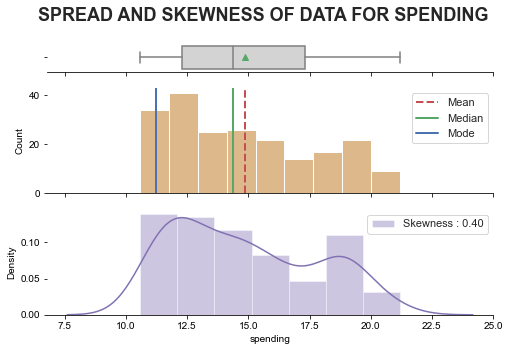

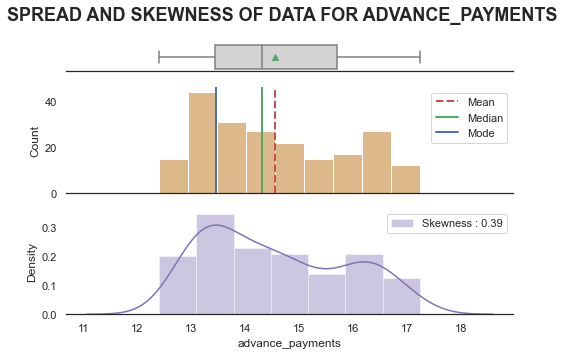

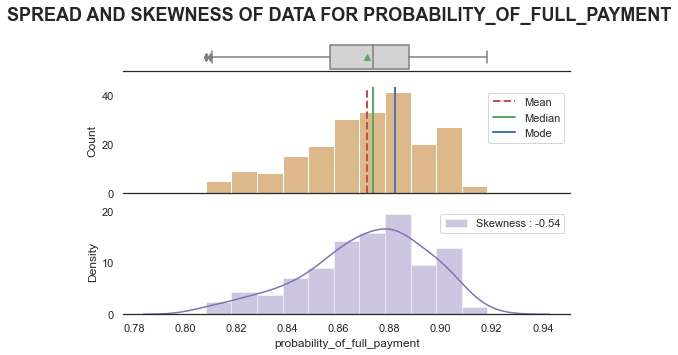

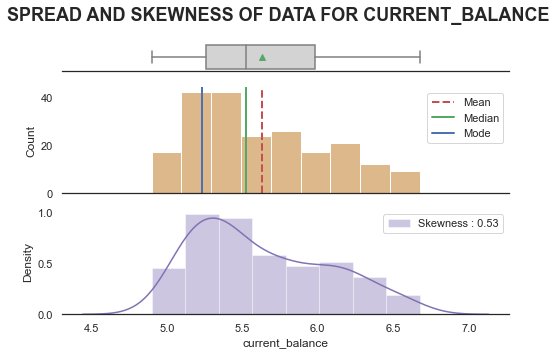

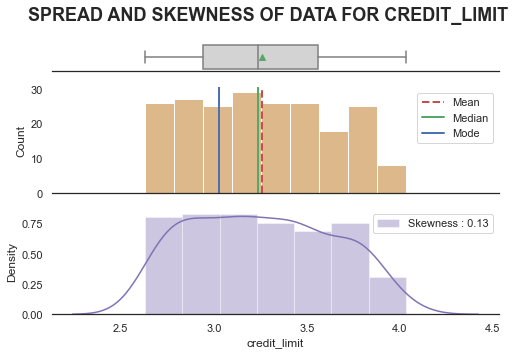

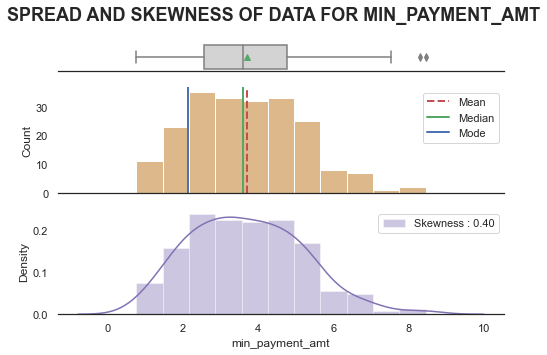

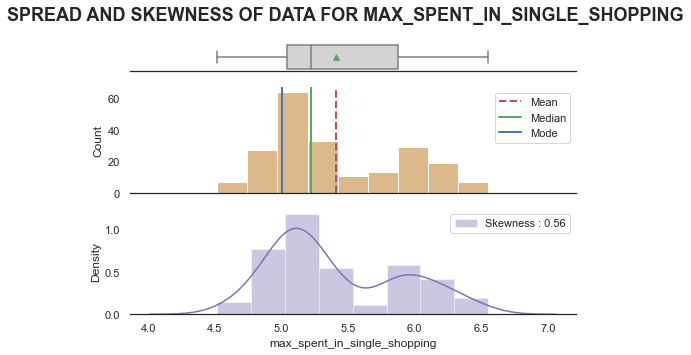

In [12]:
list_col=  ['spending', 'advance_payments', 'probability_of_full_payment',
       'current_balance', 'credit_limit', 'min_payment_amt',
       'max_spent_in_single_shopping']
for i in range(len(list_col)):
    dist_box(df[list_col[i]])

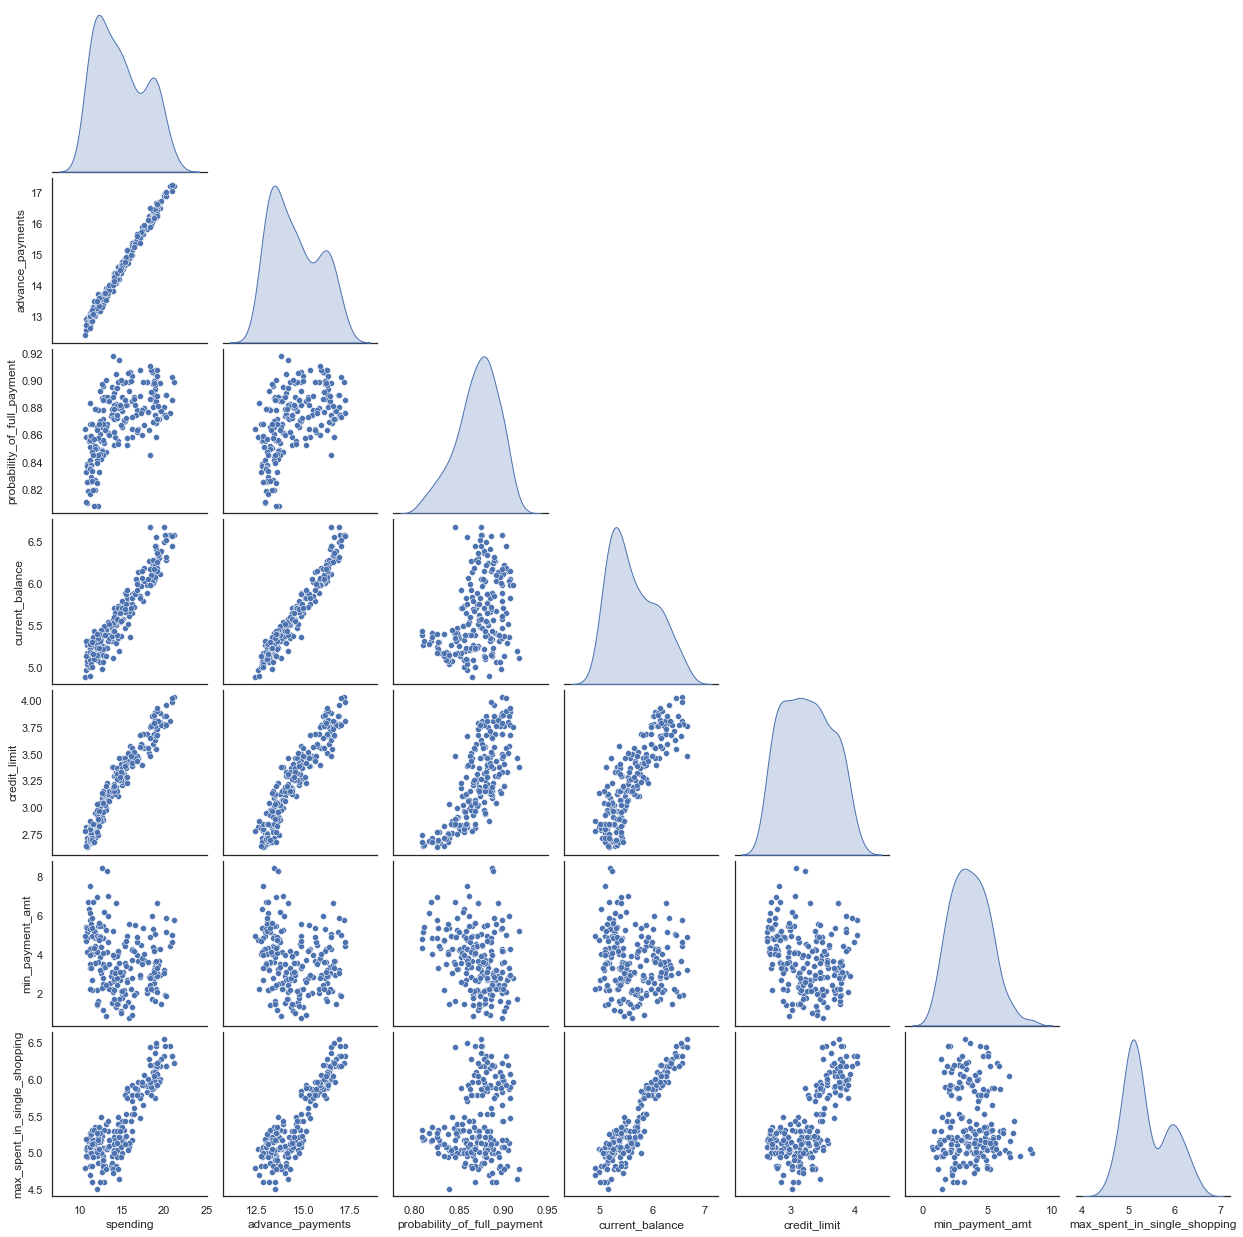

In [13]:
sns.pairplot(data=df,diag_kind='kde',corner=True)

In [14]:
corr=df.corr()


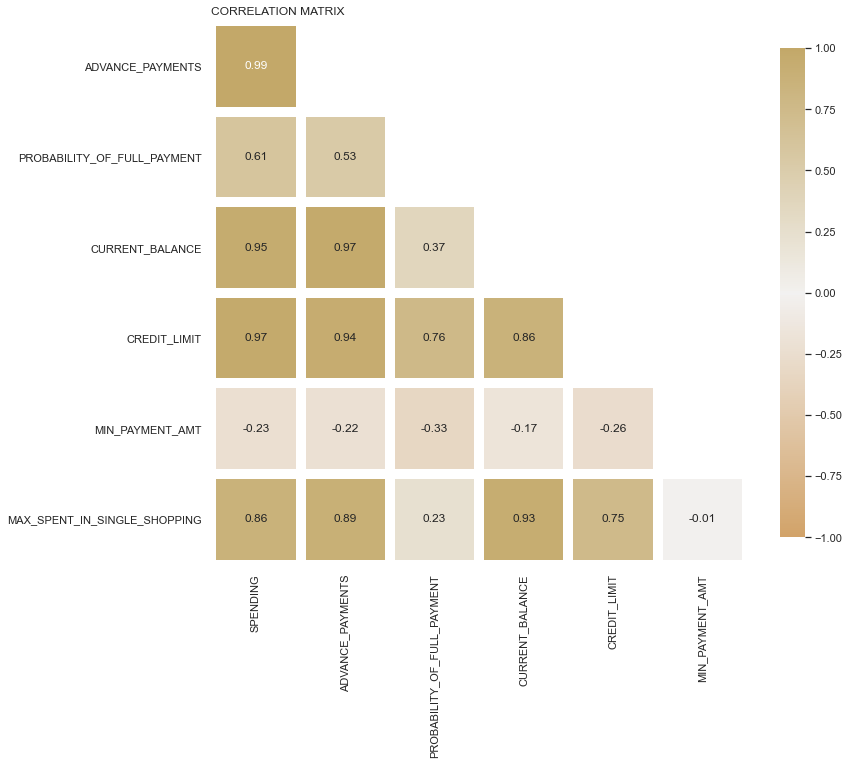

In [15]:
items = df[df.columns[:df.columns.size]]
items_corr=items.corr()


fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(items_corr, dtype=bool))
mask = mask[1:, :-1]
corr = items.corr().iloc[1:,:-1].copy()

cmap1 = sns.diverging_palette(51,65, 62,70, as_cmap=True)

_=sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", 
           linewidths=9, cmap=cmap1, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .9}, square=False)
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0
           
          )
plt.xticks(plt.xticks()[0], labels=xticks,rotation=90)
title = 'CORRELATION MATRIX';
plt.title(title, fontsize=12,loc='left');


In [16]:
df_out=df.copy()

In [17]:
def outliers(data):
        outliers_num = data.loc[:,data.columns != 'class']
        Q1 = outliers_num.quantile(0.25)
        Q3 =  outliers_num.quantile(0.75)
        IQR = Q3-Q1
        count = 0
        
        outliers_num_test = ((outliers_num <(Q1-1.5 * IQR)) | (outliers_num > (Q3+1.5 * IQR)))
        for col in outliers_num_test:
            if(1 in outliers_num_test[col].value_counts().index):
                print ("No. of outliers in %s: %d"% (col,outliers_num_test[col].value_counts().iloc[1]))
                count +=1
        print("\n\nNo of attributes with outliers are :", count)
outliers(df_out)

No. of outliers in probability_of_full_payment: 3
No. of outliers in min_payment_amt: 2


No of attributes with outliers are : 2


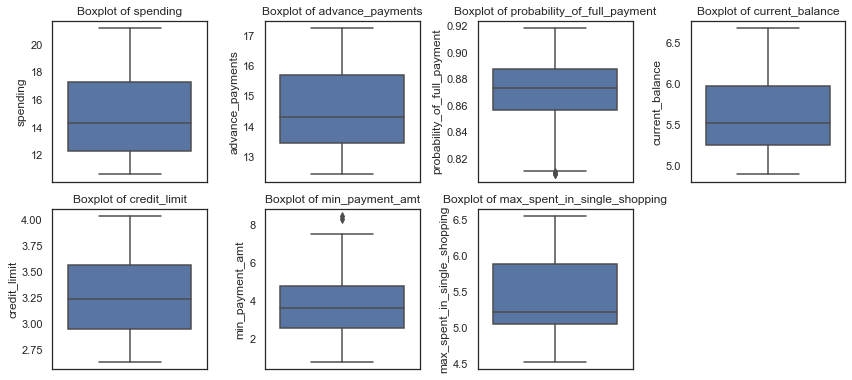

In [18]:
#Checking the outliers
plt.figure(figsize = (12,8))
feature_list = df_out.columns
for i in range(len(feature_list)):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(y = df_out[feature_list[i]], data = df_out)
    plt.title('Boxplot of {}'.format(feature_list[i]))
    plt.tight_layout()

In [19]:
#Define a function which returns the Upper and Lower limit to detect outliers for each feature
def remove_outlier(col):
    Q1,Q3=col.quantile([0.25,0.75])
    IQR=Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range   

In [20]:

#Cap & floor the values beyond the outlier boundaries
for i in feature_list:
    LL, UL = remove_outlier(df_out[i])
    df_out[i] = np.where(df_out[i] > UL, UL, df_out[i])
    df_out[i] = np.where(df_out[i] < LL, LL, df_out[i])

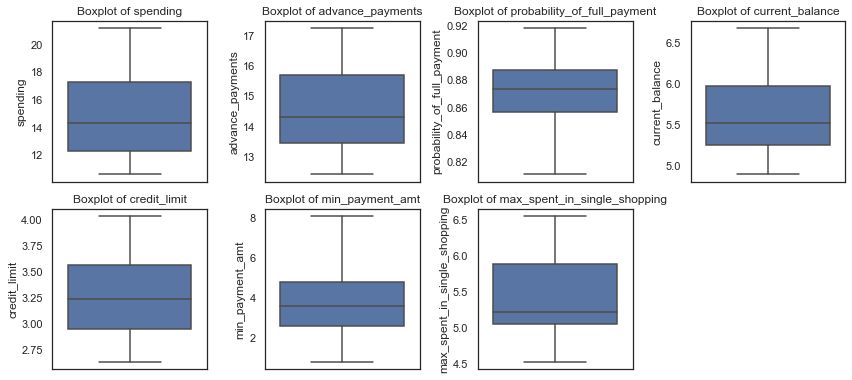

In [21]:
#Check to verify if outliers have been treated
plt.figure(figsize = (12,8))

for i in range(len(feature_list)):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(y = df_out[feature_list[i]], data = df_out)
    plt.title('Boxplot of {}'.format(feature_list[i]))
    plt.tight_layout()

In [22]:
#verifying the outliers treatment
def outliers(data):
        outliers_num = data.loc[:,data.columns != 'class']
        Q1 = outliers_num.quantile(0.25)
        Q3 =  outliers_num.quantile(0.75)
        IQR = Q3-Q1
        count = 0
        
        outliers_num_test = ((outliers_num <(Q1-1.5 * IQR)) | (outliers_num > (Q3+1.5 * IQR)))
        for col in outliers_num_test:
            if(1 in outliers_num_test[col].value_counts().index):
                print ("No. of outliers in %s: %d"% (col,outliers_num_test[col].value_counts().iloc[1]))
                count +=1
        print("\n\nNo of attributes with outliers are :", count)
outliers(df_out)



No of attributes with outliers are : 0


## 1.2  Scaling 

In [23]:

df_scaled=df_out.apply(zscore)
round(df_scaled.describe(),2).T

,count,mean,std,min,25%,50%,75%,max
spending,210.0,0.0,1.0,-1.47,-0.89,-0.17,0.85,2.18
advance_payments,210.0,0.0,1.0,-1.65,-0.85,-0.18,0.89,2.07
probability_of_full_payment,210.0,0.0,1.0,-2.57,-0.60,0.10,0.71,2.01
current_balance,210.0,-0.0,1.0,-1.65,-0.83,-0.24,0.79,2.37
credit_limit,210.0,-0.0,1.0,-1.67,-0.83,-0.06,0.80,2.06
min_payment_amt,210.0,0.0,1.0,-1.97,-0.76,-0.07,0.72,2.94
max_spent_in_single_shopping,210.0,-0.0,1.0,-1.81,-0.74,-0.38,0.96,2.33


## 1.3 Apply hierarchical clustering to scaled data. Identify the number of optimum clusters using Dendrogram



In [24]:
###Method - ward
wardlink = linkage(df_scaled, method = 'ward',)

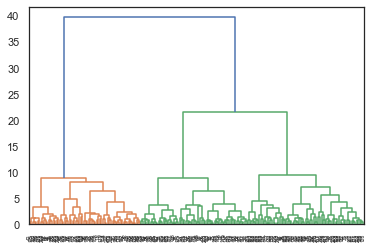

In [25]:
dend = dendrogram(wardlink)


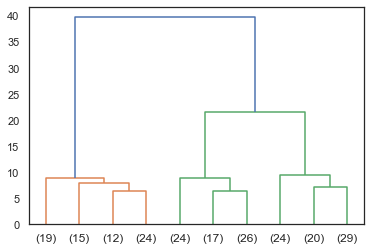

In [26]:
dend = dendrogram(wardlink,
                 truncate_mode='lastp',
                 p = 10,
                 )

In [27]:
clusters = fcluster(wardlink, 3, criterion='maxclust')
clusters

array([1, 3, 1, 2, 1, 2, 2, 3, 1, 2, 1, 3, 2, 1, 3, 2, 3, 2, 3, 2, 2, 2,
       1, 2, 3, 1, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 1, 1, 3, 1, 1,
       2, 2, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 3, 2, 2, 3, 3, 1,
       1, 3, 1, 2, 3, 2, 1, 1, 2, 1, 3, 2, 1, 3, 3, 3, 3, 1, 2, 3, 3, 1,
       1, 2, 3, 1, 3, 2, 2, 1, 1, 1, 2, 1, 2, 1, 3, 1, 3, 1, 1, 2, 2, 1,
       3, 3, 1, 2, 2, 1, 3, 3, 2, 1, 3, 2, 2, 2, 3, 3, 1, 2, 3, 3, 2, 3,
       3, 1, 2, 1, 1, 2, 1, 3, 3, 3, 2, 2, 3, 2, 1, 2, 3, 2, 3, 2, 3, 3,
       3, 3, 3, 2, 3, 1, 1, 2, 1, 1, 1, 2, 1, 3, 3, 3, 3, 2, 3, 1, 1, 1,
       3, 3, 1, 2, 3, 3, 3, 3, 1, 1, 3, 3, 3, 2, 3, 3, 2, 1, 3, 1, 1, 2,
       1, 2, 3, 1, 3, 2, 1, 3, 1, 3, 1, 3], dtype=int32)

In [28]:
df_clstr_ward=df.copy()
df_clstr_ward['clusters'] = clusters

In [29]:
df_clstr_ward.clusters.value_counts().sort_index()

1    70
2    67
3    73
Name: clusters, dtype: int64

In [30]:
agg_df=df_clstr_ward.groupby('clusters').mean()
agg_df['Freq']=df_clstr_ward['clusters'].value_counts().sort_index()
agg_df

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,Freq
clusters,,,,,,,,
1,18.371429,16.145429,0.884400,6.158171,3.684629,3.639157,6.017371,70
2,11.872388,13.257015,0.848072,5.238940,2.848537,4.949433,5.122209,67
3,14.199041,14.233562,0.879190,5.478233,3.226452,2.612181,5.086178,73


In [31]:
### Method - average
wardlink_1 = linkage(df_scaled, method = 'average')

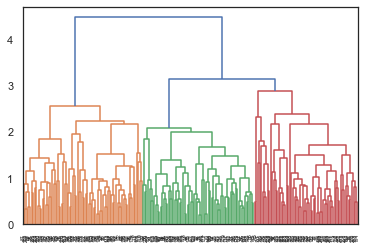

In [32]:
dend_1 = dendrogram(wardlink_1)

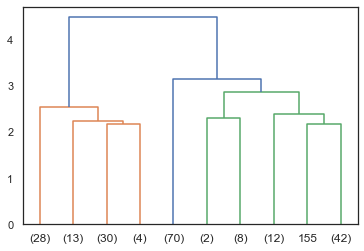

In [33]:
dend_1 = dendrogram(wardlink_1,
                 truncate_mode='lastp',
                 p = 10,
                 )

In [34]:
clusters_avg = fcluster(wardlink_1, 3, criterion='maxclust')
clusters_avg

array([1, 3, 1, 2, 1, 3, 2, 2, 1, 2, 1, 1, 2, 1, 3, 3, 3, 2, 2, 2, 2, 2,
       1, 2, 3, 1, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 1, 1, 3, 1, 1,
       2, 2, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 3, 2, 2, 1, 3, 1,
       1, 3, 1, 2, 3, 2, 1, 1, 2, 1, 3, 2, 1, 3, 3, 3, 3, 1, 2, 1, 1, 1,
       1, 3, 3, 1, 3, 2, 2, 1, 1, 1, 2, 1, 3, 1, 3, 1, 3, 1, 1, 2, 3, 1,
       1, 3, 1, 2, 2, 1, 3, 3, 2, 1, 3, 2, 2, 2, 3, 3, 1, 2, 3, 3, 2, 3,
       3, 1, 2, 1, 1, 2, 1, 3, 3, 3, 2, 2, 2, 2, 1, 2, 3, 2, 3, 2, 3, 1,
       3, 3, 2, 2, 3, 1, 1, 2, 1, 1, 1, 2, 1, 3, 3, 2, 3, 2, 3, 1, 1, 1,
       3, 2, 3, 2, 3, 2, 3, 3, 1, 1, 3, 1, 3, 2, 3, 3, 2, 1, 3, 1, 1, 2,
       1, 2, 3, 3, 3, 2, 1, 3, 1, 3, 3, 1], dtype=int32)

In [35]:
df_clstr_avg=df.copy()
df_clstr_avg['clusters'] = clusters_avg

In [36]:
df_clstr_avg.clusters.value_counts().sort_index()

1    75
2    70
3    65
Name: clusters, dtype: int64

In [37]:
agg_df_w=df_clstr_avg.groupby('clusters').mean()
agg_df_w['Freq']=df_clstr_avg['clusters'].value_counts().sort_index()
agg_df_w

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,Freq
clusters,,,,,,,,
1,18.129200,16.058000,0.881595,6.135747,3.648120,3.650200,5.987040,75
2,11.916857,13.291000,0.846766,5.258300,2.846000,4.619000,5.115071,70
3,14.217077,14.195846,0.884869,5.442000,3.253508,2.768418,5.055569,65


## 1.4 Apply K-Means clustering on scaled data and determine optimum clusters. Apply elbow curve and silhouette score. 

In [38]:
wss = []
for i in range(1,11):
        KM = KMeans(n_clusters=i)
        KM.fit(df_scaled)
        wss.append(KM.inertia_)
wss

[1469.999999999999,
 659.14740095485,
 430.298481751223,
 370.86859623942047,
 327.1172172640227,
 290.34612692516265,
 263.3007514164692,
 240.40696542754148,
 226.93776195071746,
 204.54648734688556]

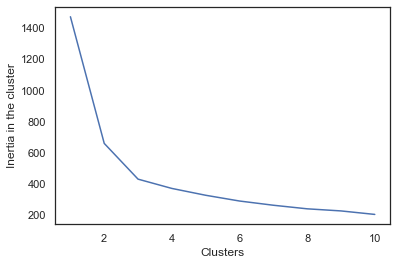

In [39]:
plt.plot(range(1,11), wss)
plt.xlabel("Clusters")
plt.ylabel("Inertia in the cluster")
plt.show()

In [40]:
sil = []
k_range = range(2, 11)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=123)
    km.fit(df_scaled)
    sil.append(metrics.silhouette_score(df_scaled, km.labels_))
    
sil

[0.46560100442748986,
 0.40212875241666574,
 0.33510889044361797,
 0.2865029823206864,
 0.2830249079548843,
 0.2811202832161459,
 0.2625014892032966,
 0.2645711172250868,
 0.261339373825621]

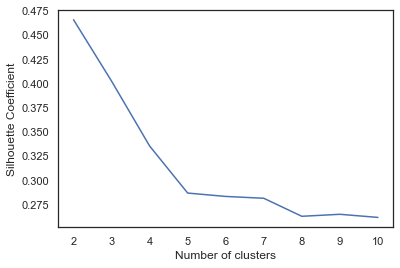

In [41]:
plt.plot(k_range,sil)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [42]:
kmean4 = KMeans(n_clusters=4,random_state=123)

In [43]:
kmean4.fit(df_scaled)
labels4=kmean4.labels_

In [44]:
pd.Series(kmean4.labels_).value_counts()

3    65
1    64
0    51
2    30
dtype: int64

In [45]:
silhouette_score(df_scaled,labels4) #score

0.33510889044361797

In [46]:
kmean3 = KMeans(n_clusters=3,random_state=123)

In [47]:
kmean3.fit(df_scaled)
labels=kmean3.labels_

In [48]:
pd.Series(kmean3.labels_).value_counts()

2    72
1    71
0    67
dtype: int64

In [49]:
silhouette_score(df_scaled,labels)#score 

0.40212875241666574

In [50]:
df_kmeans=df.copy()
df_kmeans['cluster']=labels


In [53]:
kmeans_mean_cluster = pd.DataFrame(round(df_kmeans.groupby('cluster').mean(),1))
kmeans_mean_cluster

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping
cluster,,,,,,,
0,18.5,16.2,0.9,6.2,3.7,3.6,6.0
1,11.9,13.3,0.8,5.2,2.8,4.8,5.1
2,14.4,14.3,0.9,5.5,3.3,2.7,5.1


In [54]:
agg_df_w

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,Freq
clusters,,,,,,,,
1,18.129200,16.058000,0.881595,6.135747,3.648120,3.650200,5.987040,75
2,11.916857,13.291000,0.846766,5.258300,2.846000,4.619000,5.115071,70
3,14.217077,14.195846,0.884869,5.442000,3.253508,2.768418,5.055569,65
